## ANN
- keras를 이용한 ANN 모델 구축

### 데이터 준비

In [131]:
import glob
base_path = './xray_classification_pneumonia/Dataset_compressed/train'
file_path = list(glob.glob(base_path + "/*/*.*"))

pneumonia = list(glob.glob(base_path+"/PNEUMONIA/*.*"))
normal = list(glob.glob(base_path+"/NORMAL/*.*"))

In [132]:
label_name={
    0:'Normal',
    1:'pneumonia'
}

In [133]:
len(pneumonia), len(normal)

(3875, 1341)

In [134]:
import matplotlib.pyplot as plt
import os

test = os.path.dirname(file_path[0])
print(test)
class_name = os.path.split(os.path.dirname(test))
print(class_name)

./xray_classification_pneumonia/Dataset_compressed/train\NORMAL
('./xray_classification_pneumonia/Dataset_compressed', 'train')


In [135]:
# folder name to label
labels = []

for fp in file_path:
    tmp = os.path.dirname(fp)
    class_name = os.path.split(tmp)
    if class_name[1] == "PNEUMONIA":
        labels.append(1)
    else:
        labels.append(0)

In [136]:
import numpy as np
from tensorflow.keras.utils import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import cv2


img_width = 60
img_height = 60

dataset = np.ndarray(shape=(len(file_path), img_height*img_width), dtype=np.float32)

i=0
for _file in file_path:
    img = cv2.imread(_file, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (img_width, img_height))
    
    dataset[i] = img_resized.flatten()
    i += 1
    if i % 250 == 0:
        print(f"{i} images to array")
print("Done!")

250 images to array
500 images to array
750 images to array
1000 images to array
1250 images to array
1500 images to array
1750 images to array
2000 images to array
2250 images to array
2500 images to array
2750 images to array
3000 images to array
3250 images to array
3500 images to array
3750 images to array
4000 images to array
4250 images to array
4500 images to array
4750 images to array
5000 images to array
Done!


In [137]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [138]:
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, random_state=42)

In [139]:
len(X_train), len(X_test), len(y_train), len(y_test)

(4172, 1044, 4172, 1044)

In [140]:
y_train, y_test = map(lambda x: to_categorical(x), [y_train, y_test])

### 모델 생성

In [141]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers

In [142]:
def build():
    model = Sequential()
    model.add(Dense(100, activation='relu', input_shape=(3600,)))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    return model

model = build()
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 100)               360100    
                                                                 
 dense_16 (Dense)            (None, 50)                5050      
                                                                 
 dense_17 (Dense)            (None, 2)                 102       
                                                                 
Total params: 365,252
Trainable params: 365,252
Non-trainable params: 0
_________________________________________________________________


In [143]:
model.predict(dataset)

163/163 [==============================] - 0s 1ms/step


array([[3.3450565e-33, 1.0000000e+00],
       [1.8141166e-33, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       ...,
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [2.8157395e-30, 1.0000000e+00]], dtype=float32)

### Adam 학습

In [144]:
model_adam = build()

model_adam.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model_adam.fit(
    X_train, y_train, validation_data=(X_test, y_test), batch_size=64, epochs=20
)

Epoch 1/20
66/66 [==============================] - 1s 5ms/step - loss: 14.5893 - accuracy: 0.8138 - val_loss: 3.3240 - val_accuracy: 0.8716
Epoch 2/20
66/66 [==============================] - 0s 3ms/step - loss: 6.1430 - accuracy: 0.8574 - val_loss: 3.8856 - val_accuracy: 0.8688
Epoch 3/20
66/66 [==============================] - 0s 3ms/step - loss: 3.8192 - accuracy: 0.8881 - val_loss: 11.4998 - val_accuracy: 0.8180
Epoch 4/20
66/66 [==============================] - 0s 3ms/step - loss: 2.7916 - accuracy: 0.9180 - val_loss: 1.5263 - val_accuracy: 0.9473
Epoch 5/20
66/66 [==============================] - 0s 3ms/step - loss: 1.8699 - accuracy: 0.9331 - val_loss: 5.3307 - val_accuracy: 0.8573
Epoch 6/20
66/66 [==============================] - 0s 3ms/step - loss: 3.5392 - accuracy: 0.9012 - val_loss: 2.3804 - val_accuracy: 0.9205
Epoch 7/20
66/66 [==============================] - 0s 3ms/step - loss: 1.3276 - accuracy: 0.9465 - val_loss: 4.7284 - val_accuracy: 0.8352
Epoch 8/20
66/66 [

### 예측

In [145]:
import matplotlib.pyplot as plt
import numpy as np

predictions = model_adam.predict(X_test)
predicted_class = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

33/33 [==============================] - 0s 1ms/step


#### 정확도 계산

In [146]:
accuracy = np.mean(predicted_class == true_classes)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 92.43%


### 시각화

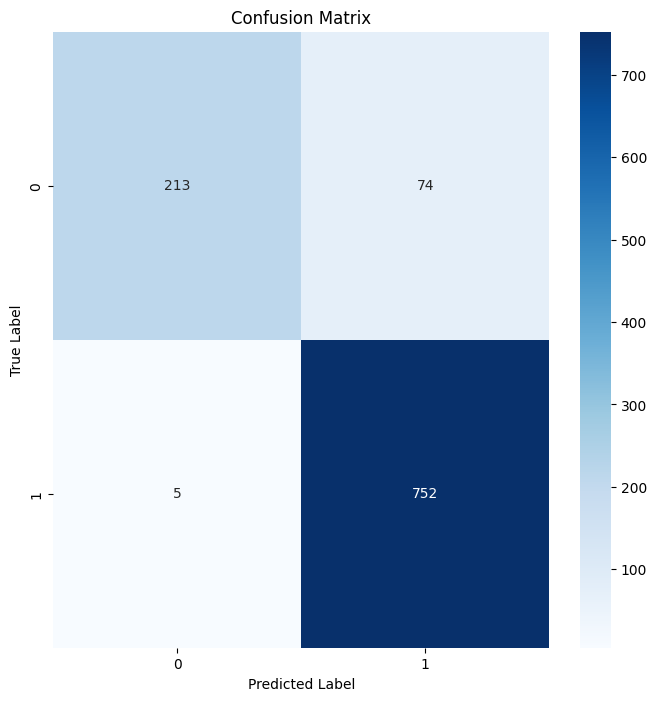

In [147]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(true_classes, predicted_class)
plt.figure(figsize=(8, 8))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

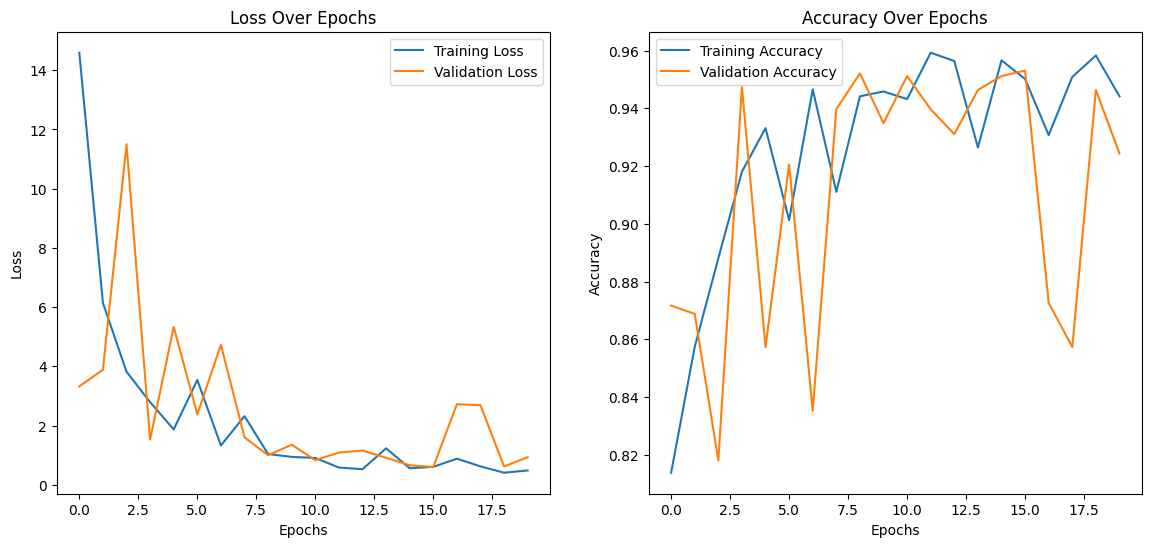

In [148]:
# Train, Val 시각화 - Loss 
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## CNN

### 데이터 준비

In [149]:
import glob
base_path = './xray_classification_pneumonia/Dataset_compressed/train'
file_path = list(glob.glob(base_path + "/*/*.*"))

pneumonia = list(glob.glob(base_path+"/PNEUMONIA/*.*"))
normal = list(glob.glob(base_path+"/NORMAL/*.*"))

In [150]:
len(pneumonia), len(normal)

(3875, 1341)

In [151]:
import matplotlib.pyplot as plt
import os

test = os.path.dirname(file_path[0])
print(test)
class_name = os.path.split(os.path.dirname(test))
print(class_name)

./xray_classification_pneumonia/Dataset_compressed/train\NORMAL
('./xray_classification_pneumonia/Dataset_compressed', 'train')


In [152]:
# folder name to label
labels = []

for fp in file_path:
    tmp = os.path.dirname(fp)
    class_name = os.path.split(tmp)
    if class_name[1] == "PNEUMONIA":
        labels.append(1)
    else:
        labels.append(0)

In [153]:
import numpy as np
from tensorflow.keras.utils import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import cv2


img_width = 60
img_height = 60

dataset = np.ndarray(shape=(len(file_path), img_height*img_width), dtype=np.float32)

i=0
for _file in file_path:
    img = cv2.imread(_file, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (img_width, img_height))
    
    dataset[i] = img_resized.flatten()
    i += 1
    if i % 250 == 0:
        print(f"{i} images to array")
print("Done!")

250 images to array
500 images to array
750 images to array
1000 images to array
1250 images to array
1500 images to array
1750 images to array
2000 images to array
2250 images to array
2500 images to array
2750 images to array
3000 images to array
3250 images to array
3500 images to array
3750 images to array
4000 images to array
4250 images to array
4500 images to array
4750 images to array
5000 images to array
Done!


In [154]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import cv2
import numpy as np

image_width = 60
image_height = 60

channels = 3

dataset = np.ndarray(shape=(len(file_path), image_height, image_width, channels),dtype=np.float32)

i=0
for _file in file_path:
    img = cv2.imread(_file, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (image_height, image_width,))
    # img.thumbnail((image_width, image_height))
    
    x = img_to_array(img)
    
    dataset[i] = x
    i += 1
    if i % 250 == 0:
        print(f"{i} images to array")
print("Done!")

250 images to array
500 images to array
750 images to array
1000 images to array
1250 images to array
1500 images to array
1750 images to array
2000 images to array
2250 images to array
2500 images to array
2750 images to array
3000 images to array
3250 images to array
3500 images to array
3750 images to array
4000 images to array
4250 images to array
4500 images to array
4750 images to array
5000 images to array
Done!


### 데이터 시각화

In [155]:
import cv2

im0 = cv2.imread(pneumonia[67])
im1 = cv2.imread(normal[67])

im0.shape, im1.shape

((60, 60, 3), (60, 60, 3))

(-0.5, 59.5, 59.5, -0.5)

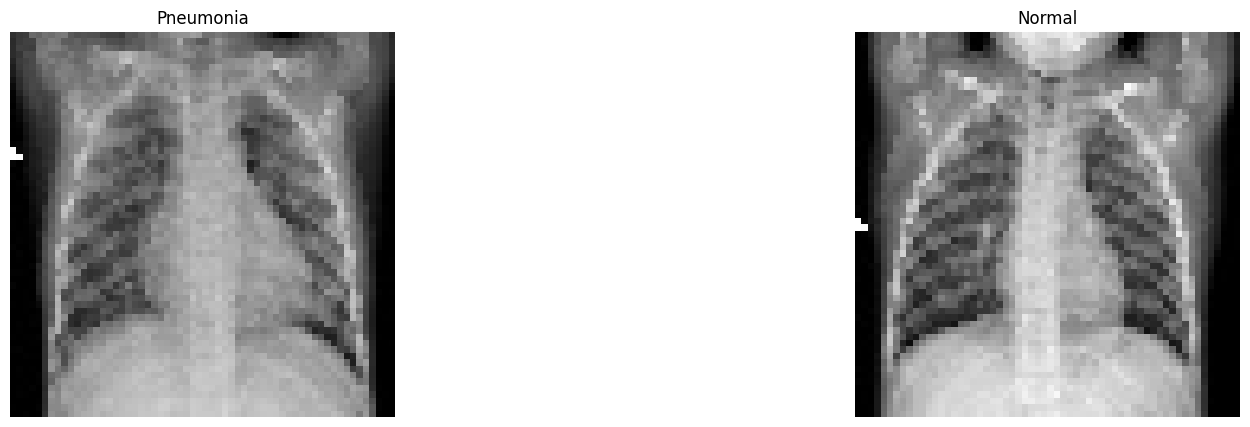

In [156]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.title('Pneumonia');plt.imshow(im0);plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Normal');plt.imshow(im1);plt.axis('off')

In [157]:
# train, val, test dataset
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

x_train, x_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, random_state=321)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)
y_train, y_test, y_val = to_categorical(y_train), to_categorical(y_test), to_categorical(y_val)

# preprocess - normalization -> /255.
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.
x_val = x_val.astype('float32')/255.

In [158]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((4172, 60, 60, 3),
 (4172, 2),
 (522, 60, 60, 3),
 (522, 2),
 (522, 60, 60, 3),
 (522, 2))

### CNN 생성

In [159]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers

In [160]:
# Vanilla CNN
def build():
    CNN = Sequential()
    
    CNN.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(60, 60, 3)))
    CNN.add(MaxPooling2D(pool_size=(2, 2)))
    
    CNN.add(Conv2D(64, (3, 3), padding='same', activation='relu',))
    CNN.add(MaxPooling2D(pool_size=(2, 2)))
    
    CNN.add(Flatten())
    CNN.add(Dense(1000, activation='relu'))
    CNN.add(Dense(500, activation='relu'))
    CNN.add(Dense(2, activation='softmax'))
    
    return CNN

In [161]:
# metric function
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true*y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true*y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (possible_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [162]:
BATCH_SIZE = 32

### 학습

In [163]:
CNN_Adam = build()

opt = optimizers.Adam(learning_rate=0.001)

CNN_Adam.compile(
    optimizer = opt,
    loss = 'categorical_crossentropy',
    metrics = ['accuracy',
               recall_m,
               precision_m,
               f1_m]
)

In [164]:
epochs = 5
history = CNN_Adam.fit(
    x_train,
    y_train,
    validation_data = (x_val, y_val),
    epochs = epochs,
    batch_size = BATCH_SIZE
)

Epoch 1/5
131/131 [==============================] - 14s 101ms/step - loss: 0.3150 - accuracy: 0.8742 - recall_m: 0.8748 - precision_m: 0.8748 - f1_m: 0.8748 - val_loss: 0.2787 - val_accuracy: 0.9061 - val_recall_m: 0.9059 - val_precision_m: 0.9059 - val_f1_m: 0.9059
Epoch 2/5
131/131 [==============================] - 13s 99ms/step - loss: 0.1462 - accuracy: 0.9434 - recall_m: 0.9437 - precision_m: 0.9437 - f1_m: 0.9437 - val_loss: 0.1068 - val_accuracy: 0.9674 - val_recall_m: 0.9688 - val_precision_m: 0.9688 - val_f1_m: 0.9688
Epoch 3/5
131/131 [==============================] - 12s 92ms/step - loss: 0.0893 - accuracy: 0.9698 - recall_m: 0.9699 - precision_m: 0.9699 - f1_m: 0.9699 - val_loss: 0.1344 - val_accuracy: 0.9521 - val_recall_m: 0.9540 - val_precision_m: 0.9540 - val_f1_m: 0.9540
Epoch 4/5
131/131 [==============================] - 12s 93ms/step - loss: 0.0737 - accuracy: 0.9741 - recall_m: 0.9742 - precision_m: 0.9742 - f1_m: 0.9742 - val_loss: 0.1252 - val_accuracy: 0.9617

### 테스트

In [165]:
score = CNN_Adam.evaluate(x_test, y_test)


17/17 [==============================] - 0s 17ms/step - loss: 0.1011 - accuracy: 0.9674 - recall_m: 0.9688 - precision_m: 0.9688 - f1_m: 0.9688


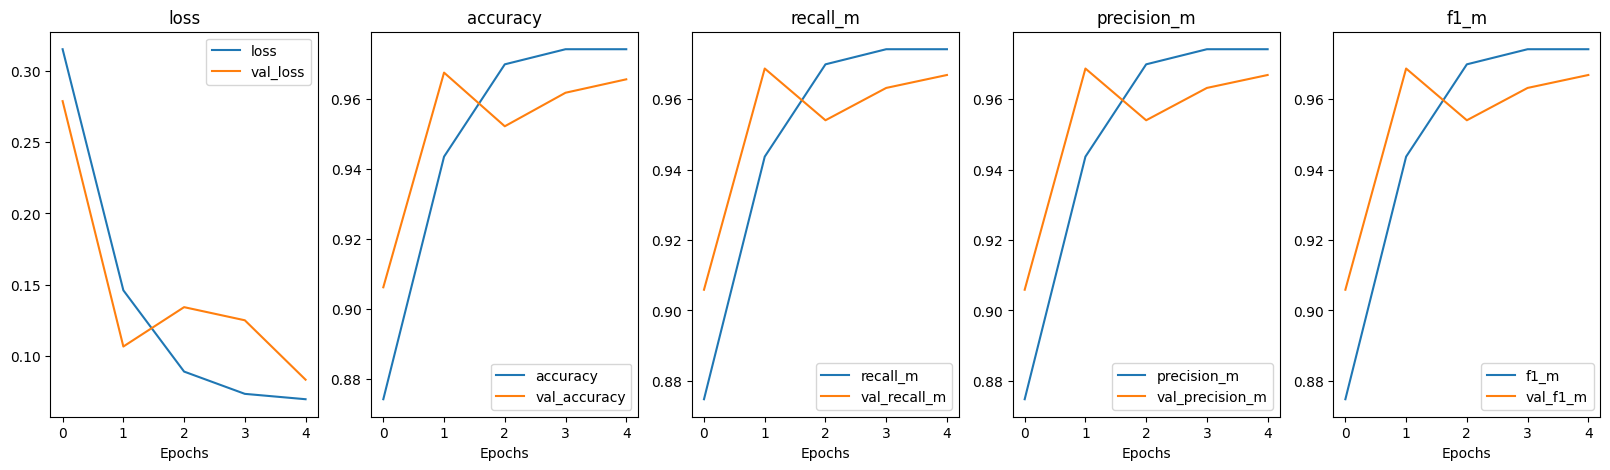

In [166]:
# 시각화
plt.figure(figsize=(20, 5))
for i, key in enumerate(list(history.history.keys())[:5]):
    plt.subplot(1, 5, i+1)
    plt.title(key)
    plt.plot(history.history[key])
    plt.plot(history.history['val_'+key])
    plt.xlabel('Epochs')
    plt.legend([key, 'val_'+key])
plt.show()

### 예측

In [167]:
y_pred = CNN_Adam.predict(x_test)

17/17 [==============================] - 0s 17ms/step


In [168]:
y_pred_argmax = np.argmax(np.array(y_pred), axis=1)
y_pred_argmax

array([0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,

In [169]:
# 예측 결과 시각화
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test.argmax(-1), y_pred_argmax))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93       128
           1       0.98      0.98      0.98       394

    accuracy                           0.97       522
   macro avg       0.95      0.96      0.96       522
weighted avg       0.97      0.97      0.97       522



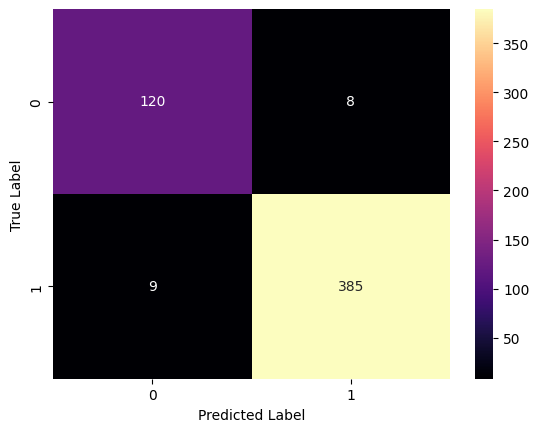

In [170]:
import seaborn as sns

heatmap = sns.heatmap(confusion_matrix(y_test.argmax(-1), y_pred_argmax), annot=True, fmt='.3g', 
                      xticklabels=['0', '1'], yticklabels=['0', '1'], cmap='magma')
heatmap.set_xlabel('Predicted Label')
heatmap.set_ylabel('True Label')
plt.show()

### Inference 

In [171]:
# 이미지 9개의 랜덤 추출 
idx=np.random.randint(0, len(x_test), 9)

In [172]:
idx

array([140, 159, 289, 143, 271, 214, 166,  85, 448])

In [173]:
import matplotlib.pyplot as plt
target_x, target_y=x_test[idx], y_test[idx]
predictions=CNN_Adam.predict(target_x)
predictions=predictions.argmax(axis=-1)

1/1 [==============================] - 0s 15ms/step


In [174]:
predictions

array([1, 1, 0, 1, 1, 1, 1, 1, 1], dtype=int64)

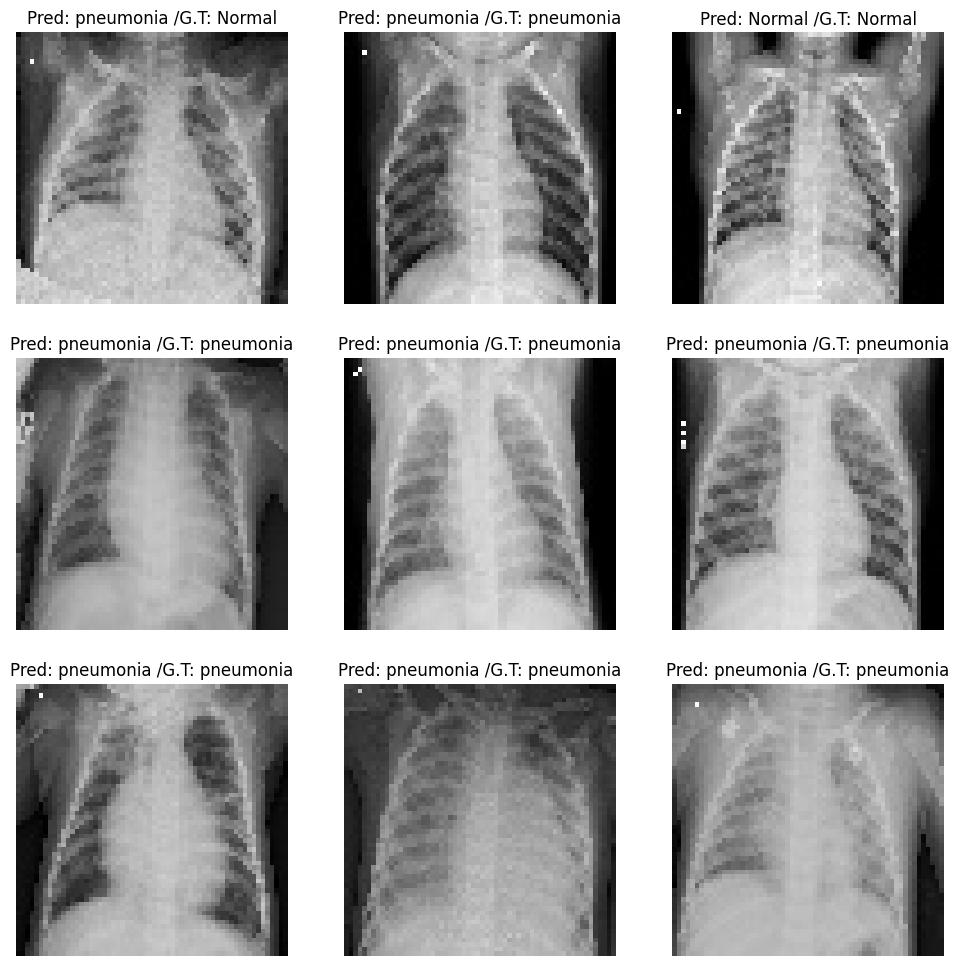

In [175]:
plt.figure(figsize=(12,12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    pred=label_name[predictions[i]]
    gth=label_name[y_test[i].argmax()]
    
    plt.title(f"Pred: {pred} /G.T: {gth}")
    
    plt.imshow(target_x[i])
    plt.axis('off')
    
plt.show()

### CNN with PyTorch

In [176]:
import torch

# tensor 생성
x=torch.tensor([1.,2.,3.])
print(x)

if torch.cuda.is_available():
    x=x.to('cuda')
    print(x)
else:
    print('unable!')


tensor([1., 2., 3.])
unable!


### 데이터 로드 및 전처리 

In [177]:
import torchvision 
import torchvision.transforms as transforms 

In [178]:
# 전처리 과정 
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5,))
])

# 데이터셋 로딩 
train=torchvision.datasets.MNIST(root='./data',train=True,download=True,transform=transform)
train_loader=torch.utils.data.DataLoader(train, batch_size=64, shuffle=True)

test=torchvision.datasets.MNIST(root='./data',train=False,download=True,transform=transform)
test_loader=torch.utils.data.DataLoader(test, batch_size=64, shuffle=False)


#### 신경망 모델 


In [179]:
import torch.nn as nn 

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN,self.__init__())
        self.conv1=nn.Conv2d(1, 6, 5) # 1: 입력채널, 6: 출력채널, 5: 커널(필터) 크기 
        self.pool=nn.MaxPool2d(2, 2) # 2: 커널크기, 2: 스트라이드 (보폭) 
        self.conv2=nn.Conv2d(6, 16, 5) # 6: 입력 채널, 16: 출력 채널, 5: 커널 크기 
        self.fc1=nn.Linear(16*4*4, 120) # 16*4*4: 입력, 120:출력 
        self.fc2=nn.Linear(120, 84)
        self.fc3=nn.Linear(84, 10)
        
    def forward(self, x):
        x=self.pool(torch.relu(self.conv1(x)))
        x=self.pool(torch.relu(self.conv2(x)))
        x=x.view(-1, 16*4*4) # flatten 
     
        
        
        